In [1]:
import numpy as np
from ABS_vertex_calc import *
import time
import matplotlib.pyplot as plt
import matplotlib.patches
import seaborn as sns
from matplotlib.colors import LogNorm

In [2]:
start = time.time()

mu_max = -5#8#0.1 #10
mu_min = -4#-9
del_mu = .1#.5 #0.25

klog_min = -3
klog_max = -.1
klog_num = 50

n_bind = 2 #types of proteins/marks

chi = None

e_m = np.array([1.52, 1.52]) #binding energy FOR F_BIND_ALT
v_int =  np.array([[-4, 4], [4, -4]])

rho_s = np.nan
chrom_type = "diblock"

M = 50
nm = M
pa_vec = np.arange(0, nm, 1) / (nm-1)
pb_vec = 1-pa_vec

poly_marks = [pa_vec, pb_vec]

vs = 1 # nm^3
A = 1
vm = 1#(N * A) / M #1**3
print("v_m = v_s = %s, %s" % (vm, vs))

phi_p = 0.7

chrom = def_chrom(n_bind, v_int, e_m, phi_p, rho_s, poly_marks, mu_max, mu_min, del_mu, vs, vm, chrom_type)
[n_bind, v_int, Vol_int, e_m, rho_p, rho_s, poly_marks, M, mu_max, mu_min, del_mu, alpha, N, N_m, b] = chrom

[pa_vec, marks_2] = poly_marks

mu1_array = np.arange(mu_min, mu_max, del_mu)
mu2_array = np.arange(mu_min, mu_max, del_mu)

k_vec = np.logspace(klog_min, klog_max, klog_num) / b

A = 1
v_s = A*b
vol_terms = [phi_p, A, v_s]

print("N = ", N)
# print("alpha = ", alpha)
print("rho_s (# / nm^3): ", 1-phi_p)
k_vec = np.logspace(klog_min, klog_max, klog_num) / (b)
# assert rho_p == rho_c

# s_bind_A_ALL, s_bind_B_ALL = calc_binding_states(chrom)
# print(np.round((time.time() - start)/(60),4), "mins elapsed")

v_m = v_s = 1, 1
N_m changed from 1000 to 100
N =  5000.0
rho_s (# / nm^3):  0.30000000000000004


In [3]:
N

5000.0

In [4]:

chi_array = np.arange(5, 31, 2)/(N*phi_p)

FA_array = [0.7, 0.6, 0.5, 0.4, 0.3]
# FA_array = [0.6]

In [5]:
# %%time
# k* stability analysis; single phi_p


min_eigval_arr = np.zeros((len(FA_array), len(chi_array), len(k_vec)))

min_eigval_arr_allk_DENS = np.zeros((len(FA_array), len(chi_array)))
min_eigval_arr_allk_ps = np.zeros((len(FA_array), len(chi_array)))

min_eigvec_arr = np.zeros((len(FA_array), len(chi_array), len(k_vec), 2))
min_eigvec_arr_allk_DENS = np.zeros((len(FA_array), len(chi_array), 2))

k_star_arr_DENS= np.zeros((len(FA_array), len(chi_array))) 

for i, FA in enumerate(FA_array):
        
    bind_A = np.zeros(M)
    bind_A[0:int(M*FA)] = 1
    bind_B = 1-bind_A
    
    s_bnd_A = bind_A
    s_bnd_B = bind_B
        # print("mu: ", mu)
    for j, CHI in enumerate(chi_array):
        for ik, k in enumerate(k_vec):
            chis = [CHI, 0, 0]
            G2 = gamma2_chis(chrom, s_bnd_A, s_bnd_B, k, chis, vol_terms)
            # G2 = abs.gamma2(chrom, s_bnd_A, s_bnd_B, k, CHI, vol_terms)
            val, vec = np.linalg.eigh(G2)        
            vec = vec.T
            min_val = np.min(val)            
            min_eigval_arr[i][j][ik] = min_val
            min_eigvec_arr[i][j][ik] = vec[np.where(val == min_val)]
    
    
        # all-k analysis
        # min eigvals, eigvecs at given mu1,mu2 for each k        
        min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] 
        min_vecs = min_eigvec_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])]
    
        # minimum eigenvalue at given mu1,mu2 across all ks
        minval_allk = np.min(min_vals) 
        
        # store this eigenvalue and corresponding eigenvector
        min_eigval_arr_allk_DENS[i][j] = minval_allk 
        min_eigvec_arr_allk_DENS[i][j] = min_vecs[np.where(min_vals==minval_allk)]
    
        k_star = k_vec[np.where(min_vals==minval_allk)]
        k_star_arr_DENS[i][j] = k_star

# setting all non-decomposed/ separated systems to 0 
psi_1_fluc = min_eigvec_arr_allk_DENS[:,:,0]
psi_1_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

psi_2_fluc = min_eigvec_arr_allk_DENS[:,:,1]
psi_2_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1 # unphysical value, to indicate outside of spinodal

chi_star_arr = np.zeros(len(FA_array))
for i, fa_kstar_arr in enumerate(k_star_arr_DENS):
    A = fa_kstar_arr
    m1 = A[:-1]<0 
    m2 = np.sign(A[1:]*A[:-1])==-1
    
    r = np.argwhere(np.all(np.vstack([m1,m2]), axis=0))
    ind = np.squeeze(r).tolist()
    chi_star_arr[i] = chi_array[ind]

In [33]:
# import sys

# sys.path.append("./Vertex/subroutines")


# from GAMcalc import *  # Code for calculating vertex functions
# import propagator  # propagator object used to store pre-calculated values
# import wignerD as wd # wigner D object used to store pre-calculated values

# pset=propagator.prop_set(nlam=10)
# wigset = wd.wigner_d_vals()

# for i, FA in enumerate(FA_array):
#     print("FA: ", FA)
#     print(spinodal(pset, N, FA))
#     # q_star = KS[0]
#     print(k_star_arr_DENS[i,:])
#     print("----------------------")


In [33]:
%%time
#SINGLE WAVEMODE PHASE DIAGRAM
# fa_array = [0.6, 0.5, 0.4]#[0.5]#[0.7, 0.6, 0.5, 0.4, 0.3]#[0.3, 0.325, 0.35, 0.375, 0.3875, 0.4, 0.4125, 0.425, 0.4375, 0.45, 0.475, 0.5]#[0.3, 0.35, 0.4, 0.45, 0.5]#np.arange(0.2, 0.51, .02)
# chi_array = np.arange(10, 31, 10)/N#np.arange(5, 30, 0.5)/N #np.array([5, 7, 10, 12, 15, 17, 20])/N #* N

# fa_array = [0.7, 0.6, 0.5, 0.4, 0.3]
# fa_array = [0.5]
# fa_array = [0.3, 0.5, 0.7]
# fa_array = [0.3]

# chi_array = np.arange(-1, 3, 0.1)/(N*phi_p)
# chi_array = np.arange(5, 31, 2)/(N*phi_p)

# fa_array = [0.3]
# chi_array = np.arange(14.0, 15.0, .001)/(N*phi_p)

#unrestricted
bcc_pnts_u = np.array([])
cyl_pnts_u = np.array([])
lam_pnts_u = np.array([])
dis_pnts_u = np.array([])

#physically bounded
bcc_pnts_p = np.array([])
cyl_pnts_p = np.array([])
lam_pnts_p = np.array([])
dis_pnts_p = np.array([])

#eigvect rest
bcc_pnts_e = np.array([])
cyl_pnts_e = np.array([])
lam_pnts_e = np.array([])
dis_pnts_e = np.array([])

# lam_pnts_b_fmin = np.array([])

print("all phases")
# print("JUST CYL AND BCC")

def sigmoid(z):
    return 1/(1 + np.exp(-z))

for FA in FA_array:
    print("FA: ", FA)
    # KS = spinodal(pset, N, FA)
    # q_star = KS[0]
    
    q_star = k_star_arr_DENS[i,j]
    vec_star = min_eigvec_arr_allk_DENS[i,j]
    lam_q = q_star*np.array([1, 0, 0])
    
    cyl_q1 = q_star*np.array([1, 0, 0])
    cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
    cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
    cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])
    
    bcc_q1 = 2**(-0.5)*q_star*np.array([1,1,0])
    bcc_q2 = 2**(-0.5)*q_star*np.array([-1,1,0])
    bcc_q3 = 2**(-0.5)*q_star*np.array([0,1,1])
    bcc_q4 = 2**(-0.5)*q_star*np.array([0,1,-1])
    bcc_q5 = 2**(-0.5)*q_star*np.array([1,0,1])
    bcc_q6 = 2**(-0.5)*q_star*np.array([1,0,-1])


    bind_A = np.zeros(M)
    bind_A[0:int(M*FA)] = 1
    bind_B = 1-bind_A
    
    s_bnd_A = bind_A
    s_bnd_B = bind_B

    lam_g3 = 0
    G3 = gamma3(chrom, s_bnd_A, s_bnd_B, cyl_qs, vol_terms) # all g3s are eqivlaent
    cyl_g3 = (1/6)  * (1/(3*np.sqrt(3))) * 12 * G3#
    bcc_g3 = (4/(3*np.sqrt(6))) * G3
    
    G4_00 = gamma4(chrom, s_bnd_A, s_bnd_B, np.array([lam_q, -lam_q, lam_q, -lam_q]), vol_terms)
    lam_g4 = (1/24) * (6) * (1) * G4_00#gamma4_E(poly_mat, dens, N_m, b, M, np.array([lam_q, -lam_q, lam_q, -lam_q]))        
    
    cyl_g4 = (1/24) * (1/9) *(18*G4_00 + \
      72*gamma4(chrom, s_bnd_A, s_bnd_B, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2]), vol_terms) )
    
    bcc_g4 = (1/24)* (G4_00 \
             + 8*gamma4(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q1, bcc_q3, -bcc_q3]), vol_terms) \
             + 2*gamma4(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q1, bcc_q2, -bcc_q2]), vol_terms) \
             + 4*gamma4(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q3, bcc_q2, -bcc_q4]), vol_terms) )
    
    for CHI in chi_array:
        print("CHI N phi_p: ",CHI * N * phi_p) 

        lam_g2 = (1/2) * 2 * (1) * gamma2(chrom, s_bnd_A, s_bnd_B, q_star, CHI, vol_terms)        
        cyl_g2 = lam_g2
        bcc_g2 = lam_g2

        initial = [0, 0] # A, B
        
        # UNRESTRICTED

        res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2, amps, amps) \
                                           +  np.einsum("ijkl,i,j,k,l ->", -lam_g4, amps, amps, amps, amps)), initial)
        lamF_unres = res.fun

        res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", cyl_g2, amps, amps) \
                                            + np.einsum("ijk,i,j,k ->", cyl_g3, amps, amps, amps) \
                                           +  np.einsum("ijkl,i,j,k,l ->", -cyl_g4, amps, amps, amps, amps)), initial)
        
        cylF_unres = res.fun
        
        res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", bcc_g2, amps, amps) \
                                            + np.einsum("ijk,i,j,k ->", bcc_g3, amps, amps, amps) \
                                           +  np.einsum("ijkl,i,j,k,l ->", -bcc_g4, amps, amps, amps, amps)), initial)    
        bccF_unres = res.fun

        print("unrestricted")
        print("Fs = ", [lamF_unres, cylF_unres, bccF_unres])

        # PHYSICAL BOUNDED
        phi_0 = phi_p * np.array([FA, 1-FA])
        res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
                                           +  np.einsum("ijkl,i,j,k,l ->", -lam_g4, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, \
                                                        phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0)), initial)
        lamF_physb = res.fun
        
        res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", cyl_g2, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
                                            + np.einsum("ijk,i,j,k ->", cyl_g3, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
                                           +  np.einsum("ijkl,i,j,k,l ->", -cyl_g4,  phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, \
                                                        phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0)), initial)
        cylF_physb = res.fun

        res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", bcc_g2, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
                                            + np.einsum("ijk,i,j,k ->", bcc_g3, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
                                           +  np.einsum("ijkl,i,j,k,l ->", -bcc_g4,  phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, \
                                                        phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0)), initial)
        bccF_physb = res.fun  
        
        print("physically bounded")
        print("Fs = ", [lamF_physb, cylF_physb, bccF_physb]) 

        # eigenvector restricted critical fluctutaion

        # define a lambda scalar value for a given critica lfluctutaion, then use roots equation to find cirtical points, and eval F at each
        lam_lambda_2 = np.einsum("ij,i,j ->", lam_g2, vec_star, vec_star)
        lam_lambda_4 = np.einsum("ijkl,i,j,k,l ->", -lam_g4, vec_star, vec_star, vec_star, vec_star)

        pos_l_amps = np.real(np.roots([4*lam_lambda_4,0,2*lam_lambda_2,0]))        
        lamF_eig = min(np.real( lam_lambda_2 * pos_l_amps**2 + lam_lambda_4 * pos_l_amps**4))

        
        cyl_lambda_2 = np.einsum("ij,i,j ->", cyl_g2, vec_star, vec_star)
        cyl_lambda_3 = np.einsum("ijk,i,j,k->", cyl_g3, vec_star, vec_star, vec_star)
        cyl_lambda_4 = np.einsum("ijkl,i,j,k,l ->", -cyl_g4, vec_star, vec_star, vec_star, vec_star)

        pos_c_amps = np.real(np.roots([4*cyl_lambda_4,3*cyl_lambda_3,2*cyl_lambda_2,0]))        
        cylF_eig = min(np.real( cyl_lambda_2 * pos_c_amps**2 + cyl_lambda_3*pos_c_amps**3 + cyl_lambda_4 * pos_c_amps**4))

        
        bcc_lambda_2 = np.einsum("ij,i,j ->", bcc_g2, vec_star, vec_star)
        bcc_lambda_3 = np.einsum("ijk,i,j,k->", bcc_g3, vec_star, vec_star, vec_star)
        bcc_lambda_4 = np.einsum("ijkl,i,j,k,l ->", -bcc_g4, vec_star, vec_star, vec_star, vec_star)

        pos_b_amps = np.real(np.roots([4*bcc_lambda_4,3*bcc_lambda_3,2*bcc_lambda_2,0]))        
        bccF_eig = min(np.real( bcc_lambda_2 * pos_b_amps**2 + bcc_lambda_3*pos_b_amps**3 + bcc_lambda_4 * pos_b_amps**4))        
        
        print("eigenvector restricted")
        print("Fs = ", [lamF_eig, cylF_eig, bccF_eig])
        
        point = np.array([FA, CHI*N])
        if (lamF_unres >= 0 and cylF_unres >= 0 and bccF_unres >= 0):
            #disordered stable
            dis_pnts_u = np.append(dis_pnts_u, point)
        elif (lamF_unres < cylF_unres and lamF_unres < bccF_unres):
            lam_pnts_u = np.append(lam_pnts_u, point) 
        elif (cylF_unres < bccF_unres):
            cyl_pnts_u = np.append(cyl_pnts_u, point)
        else:
            bcc_pnts_u = np.append(bcc_pnts_u, point)

        if (lamF_physb >= 0 and cylF_physb >= 0 and bccF_physb >= 0):
            #disordered stable
            dis_pnts_p = np.append(dis_pnts_p, point)
        elif (lamF_physb < cylF_physb and lamF_physb < bccF_physb):
            lam_pnts_p = np.append(lam_pnts_p, point) 
        elif (cylF_physb < bccF_physb):
            cyl_pnts_p = np.append(cyl_pnts_p, point)
        else:
            bcc_pnts_p = np.append(bcc_pnts_p, point) 

        if (lamF_eig >= 0 and cylF_eig >= 0 and bccF_eig >= 0):
            #disordered stable
            dis_pnts_e = np.append(dis_pnts_e, point)
        elif (lamF_eig < cylF_eig and lamF_eig < bccF_eig):
            lam_pnts_e = np.append(lam_pnts_e, point) 
        elif (cylF_eig < bccF_eig):
            cyl_pnts_e = np.append(cyl_pnts_e, point)
        else:
            bcc_pnts_e = np.append(bcc_pnts_e, point) 
    print("one FA done!!")
            

all phases
FA:  0.6
simple transofrmation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
CHI N phi_p:  5.0
simple transformation matrix
unrestricted
Fs =  [0.0, 0.0, 0.0]
physically bounded
Fs =  [3.972700565554156e-14, 1.5176620375876387e-12, 1.6717375133692205e-11]
eigenvector restricted
Fs =  [0.0, 0.0, 0.0]
CHI N phi_p:  7.0
simple transformation matrix
unrestricted
Fs =  [0.0, 0.0, 0.0]
physically bounded
Fs =  [2.458067182977221e-12, 3.0614187368847795e-11, 2.871586418323577e-13]
eigenvector restricted
Fs =  [0.0, 0.0, 0.0]
CHI N phi_p:  8.999999999999998
simple transformation matrix
unrestricted
Fs =  [0.0, 0.0, 0.0]
physically bounded
Fs =  [6.626662983098377e-12, 6.43102830717796e-11, 4.8662978704512006e-11]
eigenvector restricted
Fs =  [0.0, 0.0, 0.0]
CHI N phi_p:  11.0
simple transformation matrix
unrestricted
Fs =  [0.0, 0.0, 0.0]
physically bounded
Fs =  [2.324604162539

In [31]:
lam_pnts_u

array([], dtype=float64)

<Figure size 640x480 with 0 Axes>

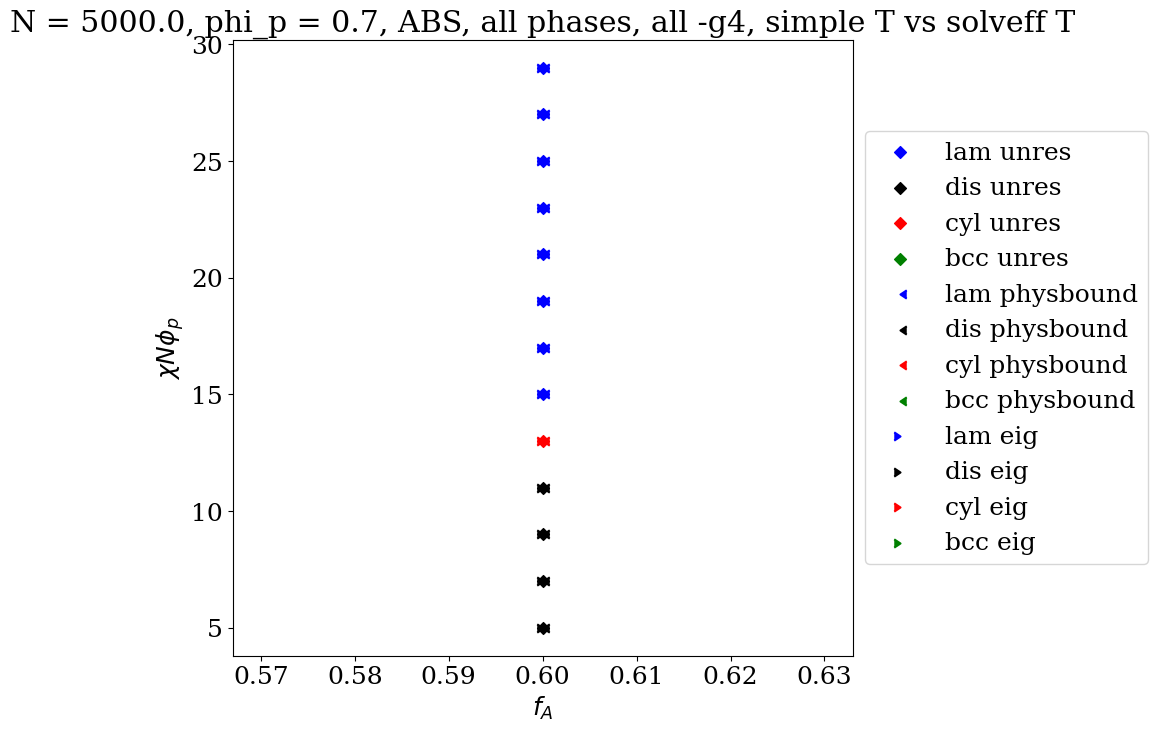

In [65]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)


ax.scatter(lam_pnts_u[::2], lam_pnts_u[1::2]*phi_p, label = "lam unres", color = "blue", marker = "D")
ax.scatter(dis_pnts_u[::2], dis_pnts_u[1::2]*phi_p, label = "dis unres", color = "black", marker = "D")
ax.scatter(cyl_pnts_u[::2], cyl_pnts_u[1::2]*phi_p, label = "cyl unres", color = "red", marker = "D")
ax.scatter(bcc_pnts_u[::2], bcc_pnts_u[1::2]*phi_p, label = "bcc unres", color = "green", marker = "D")


ax.scatter(lam_pnts_p[::2], lam_pnts_p[1::2]*phi_p, label = "lam physbound",  color = "blue", marker = 4)
ax.scatter(dis_pnts_p[::2], dis_pnts_p[1::2]*phi_p, label = "dis physbound", color = "black", marker = 4)
ax.scatter(cyl_pnts_p[::2], cyl_pnts_p[1::2]*phi_p, label = "cyl physbound", color = "red", marker = 4)
ax.scatter(bcc_pnts_p[::2], bcc_pnts_p[1::2]*phi_p, label = "bcc physbound",  color = "green", marker = 4)

ax.scatter(lam_pnts_e[::2], lam_pnts_e[1::2]*phi_p, label = "lam eig",  color = "blue", marker = 5)
ax.scatter(dis_pnts_e[::2], dis_pnts_e[1::2]*phi_p, label = "dis eig", color = "black", marker = 5)
ax.scatter(cyl_pnts_e[::2], cyl_pnts_e[1::2]*phi_p, label = "cyl eig", color = "red", marker = 5)
ax.scatter(bcc_pnts_e[::2], bcc_pnts_e[1::2]*phi_p, label = "bcc eig",  color = "green", marker = 5)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("N = " + str(N) + ", phi_p = " + str(phi_p) + ", ABS, all phases, all -g4, simple T vs solveff T")
ax.set_ylabel("$\chi N \phi_p$")
ax.set_xlabel("$f_A$")

plt.savefig('ABS_min_comp.png')